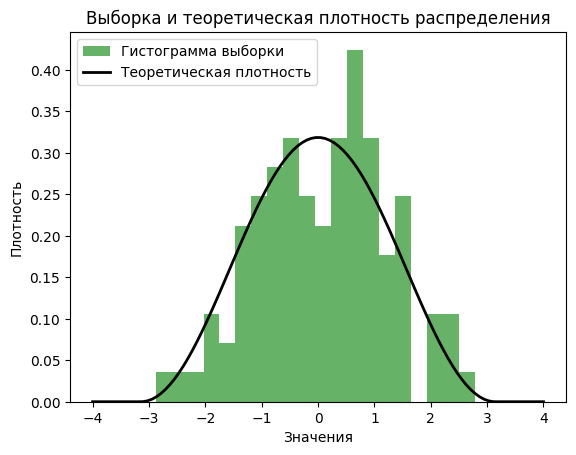

Выборочное среднее: 0.10400273887807025
Выборочная дисперсия: 1.3471299647920338


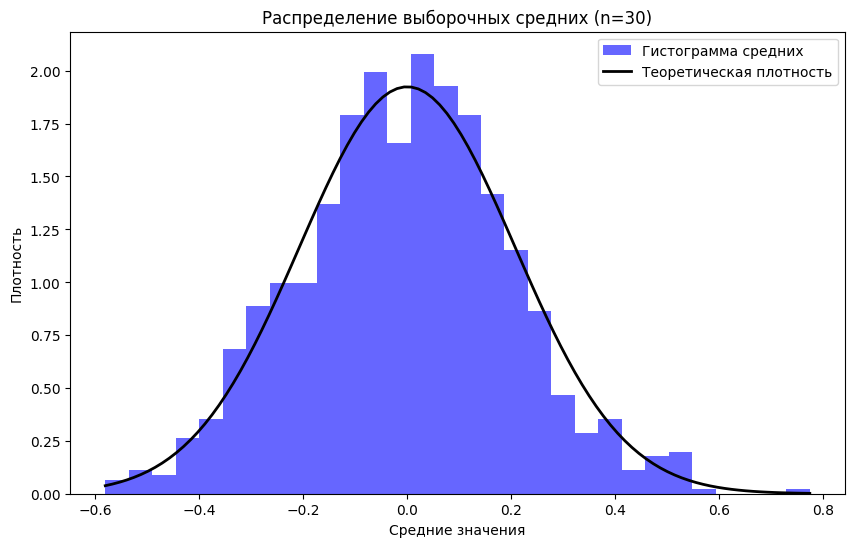

Среднее значение выборочных средних (n=30): -0.0042
Дисперсия выборочных средних (n=30): 0.0414


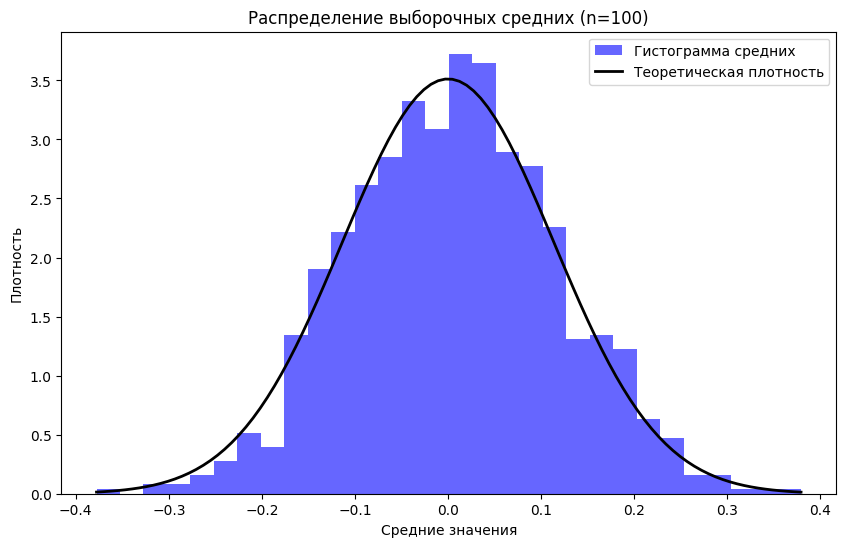

Среднее значение выборочных средних (n=100): 0.0062
Дисперсия выборочных средних (n=100): 0.0124


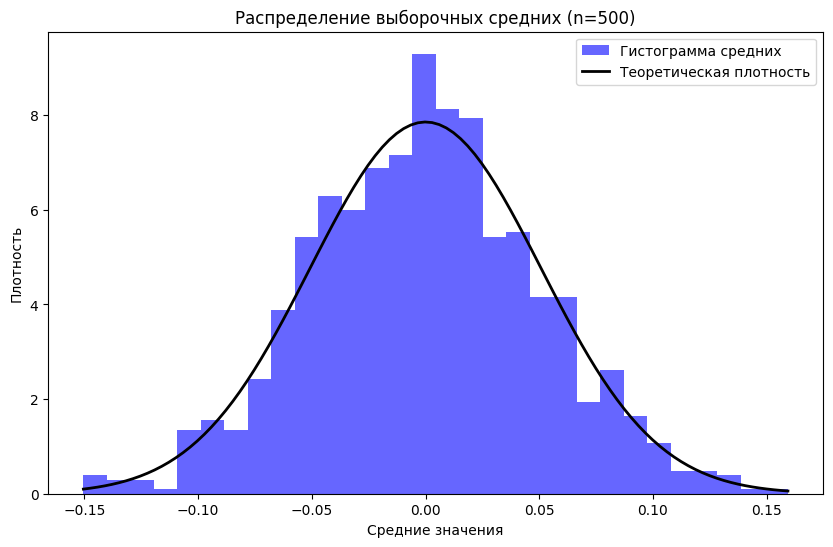

Среднее значение выборочных средних (n=500): -0.0002
Дисперсия выборочных средних (n=500): 0.0025
Churn Status: False
Среднее: 100.28
Дисперсия: 392.09
Количество: 2850.0
Доверительный интервал (ручной расчет): (np.float64(99.55618833318324), np.float64(101.01012745629045))
Доверительный интервал (statsmodels): (np.float64(99.55618833318324), np.float64(101.01012745629045))

Churn Status: True
Среднее: 101.34
Дисперсия: 465.80
Количество: 483.0
Доверительный интервал (ручной расчет): (np.float64(99.41066229112079), np.float64(103.26014516229537))
Доверительный интервал (statsmodels): (np.float64(99.41066229112079), np.float64(103.26014516229537))



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from statsmodels.stats.weightstats import _zconfint_generic

# Для отображения графиков
%matplotlib inline

# Генерация данных из косинусного распределения
cosine_distribution = stats.cosine()
data_sample = cosine_distribution.rvs(size=100)

# Реальные параметры распределения
true_mean = cosine_distribution.mean()  # Математическое ожидание
true_variance = cosine_distribution.var()  # Дисперсия

# Построение гистограммы данных и теоретической плотности распределения
plt.hist(data_sample, bins=20, density=True, alpha=0.6, color='green', label='Гистограмма выборки')
x_values = np.linspace(-4, 4, 100)
pdf_values = cosine_distribution.pdf(x_values)
plt.plot(x_values, pdf_values, color='black', lw=2, label='Теоретическая плотность')
plt.xlabel('Значения')
plt.ylabel('Плотность')
plt.title('Выборка и теоретическая плотность распределения')
plt.legend()
plt.show()

# Выборочные средние и дисперсия
mean_sample = np.mean(data_sample)
variance_sample = np.var(data_sample)
print(f"Выборочное среднее: {mean_sample}")
print(f"Выборочная дисперсия: {variance_sample}")

# Функция для построения распределения выборочных средних
def plot_distribution_of_sample_means(dist, n_samples, num_iterations=1000, mean_true=0, variance_true=1, save_as=None):
    sample_means = [np.mean(dist.rvs(size=n_samples)) for _ in range(num_iterations)]
    
    plt.figure(figsize=(10, 6))
    plt.hist(sample_means, bins=30, density=True, alpha=0.6, color='blue', label='Гистограмма средних')
    
    # Теоретическая плотность распределения
    x_vals = np.linspace(min(sample_means), max(sample_means), 100)
    pdf_theoretical = stats.norm.pdf(x_vals, loc=mean_true, scale=math.sqrt(variance_true / n_samples))
    plt.plot(x_vals, pdf_theoretical, 'k-', lw=2, label='Теоретическая плотность')
    
    plt.xlabel('Средние значения')
    plt.ylabel('Плотность')
    plt.title(f'Распределение выборочных средних (n={n_samples})')
    plt.legend()
    
    if save_as:
        plt.savefig(save_as)  # Сохранение графика
    
    plt.show()
    
    print(f'Среднее значение выборочных средних (n={n_samples}): {np.mean(sample_means):.4f}')
    print(f'Дисперсия выборочных средних (n={n_samples}): {np.var(sample_means, ddof=1):.4f}')

# Примеры с разными объемами выборок
plot_distribution_of_sample_means(cosine_distribution, n_samples=30, num_iterations=1000, mean_true=true_mean, variance_true=true_variance, save_as='means_distribution_30.png')
plot_distribution_of_sample_means(cosine_distribution, n_samples=100, num_iterations=1000, mean_true=true_mean, variance_true=true_variance, save_as='means_distribution_100.png')
plot_distribution_of_sample_means(cosine_distribution, n_samples=500, num_iterations=1000, mean_true=true_mean, variance_true=true_variance, save_as='means_distribution_500.png')

# Загрузка данных из файла
df = pd.read_csv("https://raw.githubusercontent.com/piton1/DS/Lesson_5/telecom_churn.csv")

# Группировка данных по признаку оттока
grouped_data = df.groupby('churn')['total day calls']

# Подсчет статистик для каждой группы
statistics = grouped_data.agg(['mean', 'var', 'count'])

# Функция для расчета доверительного интервала
def get_confidence_interval(mean, variance, sample_size, confidence_level=0.95):
    standard_error = math.sqrt(variance / sample_size)
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    return (mean - z_score * standard_error, mean + z_score * standard_error)

# Подсчет доверительных интервалов для каждой группы
interval_results = {}
for churn_status, row in statistics.iterrows():
    mean_value = row['mean']
    variance_value = row['var']
    sample_count = row['count']
    ci_manual = get_confidence_interval(mean_value, variance_value, sample_count)
    
    # Проверка с помощью _zconfint_generic
    standard_error = math.sqrt(variance_value / sample_count)
    ci_statsmodels = _zconfint_generic(mean_value, standard_error, alpha=0.05, alternative='two-sided')
    
    interval_results[churn_status] = {
        'mean': mean_value,
        'variance': variance_value,
        'count': sample_count,
        'ci_manual': ci_manual,
        'ci_statsmodels': ci_statsmodels
    }

# Вывод результатов
for churn_status, result in interval_results.items():
    print(f"Churn Status: {churn_status}")
    print(f"Среднее: {result['mean']:.2f}")
    print(f"Дисперсия: {result['variance']:.2f}")
    print(f"Количество: {result['count']}")
    print(f"Доверительный интервал (ручной расчет): {result['ci_manual']}")
    print(f"Доверительный интервал (statsmodels): {result['ci_statsmodels']}")
    print()

# Анализ данных и визуализация

Этот ноутбук демонстрирует генерацию данных из косинусного распределения, построение гистограмм, расчет статистик выборки и доверительных интервалов. Также выполняется загрузка данных, их группировка и расчет статистик по группам.